In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import librosa
import librosa.display
import os
import copy
import torch
from torch.utils.data import Dataset, DataLoader
import random
import skimage.io as io
import pandas as pd
import torchaudio.transforms as T
from torchvision.models import resnet18, resnet50
from tqdm import tqdm

/opt/conda/lib/python3.7/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [2]:
def seed_everything(seed=42):
    print(f'setting everything to seed {seed}')
    #os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU.
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    torch.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    
def worker_init_fn(worker_id):
    t = np.random.get_state()[1][0] + worker_id
    np.random.seed(t)
    random.seed(t)

In [3]:
device = torch.device('cuda:0')

In [4]:
data_dir = '//kaggle/input/heartbeat-sounds/set_b'
file_csv = '/kaggle/input/heartbeat-sounds/set_b.csv'

In [5]:
def normalize(X, eps=1e-6, mean=None, std=None):
    # Standardize
    mean = mean or X.mean()
    std = std or X.std()
    X = (X - mean) / (std + eps)
    return X.astype(np.float32)

In [6]:
NUM_SAMPLES = 65500
sr = 48000
fmin = 84
fmax = sr // 2
nmels = 128
batch_size = 32
train_size = 0.8

augmentation_list = ['TimeCycleShift', 'TimeSwapAugmentation', 'TimeRandomSwap', 'TimeReplyMasking']

In [7]:
recordings_old = sorted(os.listdir(data_dir))

In [8]:
recordings = []
for x in recordings_old:
    y, _ = librosa.load(data_dir + '/' + x, sr = sr)
    if y.shape[0] >= NUM_SAMPLES:
        recordings.append(x)

In [9]:
len(recordings)

638

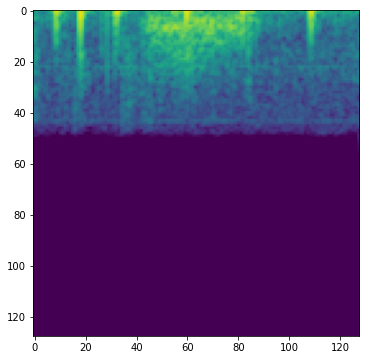

In [10]:
y, _ = librosa.load(data_dir + '/' + recordings[200], sr = sr)
begin = (len(y) - NUM_SAMPLES) // 2
samples = y[begin:begin + NUM_SAMPLES]
melspec = librosa.feature.melspectrogram(samples, sr=sr, n_mels = nmels, fmin=fmin, fmax=fmax)
melspec = librosa.power_to_db(melspec)
melspec = normalize(melspec, mean=None, std=None)
plt.figure(figsize = (20, 6))
plt.imshow(melspec)
plt.show()

In [11]:
image_size = melspec.shape
image_size

(128, 128)

In [12]:
melspec = torch.tensor(melspec)
melspec = torch.stack([melspec, melspec, melspec])

In [13]:
def noise_augmentation(im, var = 0.01):
    noise = var * torch.randn(im.shape[1], im.shape[2])
    im[0, :, :] += noise
    im[1, :, :] += noise
    im[2, :, :] += noise
    return im

def time_shift_augmentation(image, max_shift = 25):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        image[:, :, shift:] = image[:, :, :image.shape[2] - shift]
        image[:, :, :shift] = 0.0
    else:
        image[:, :, :image.shape[2] - shift] = image[:, :, shift:]
        image[:, :, image.shape[2] - shift:] = 0.0
    return image

def TimeCycleShift(image, max_shift = 25):
    shift = np.random.randint(max_shift)
    p = np.random.rand()
    if p < 0.5:
        t = image[:, :, image.shape[2] - shift:].clone()
        image[:, :, shift:] = image[:, :, :image.shape[2] - shift]
        image[:, :, :shift] = t
    else:
        t = image[:, :, :shift].clone()
        image[:, :, :image.shape[2] - shift] = image[:, :, shift:]
        image[:, :, image.shape[2] - shift:] = t
    return image

def TimeSwapAugmentation(image, max_b = 25):
    b = np.random.randint(max_b)
    b0 = np.random.randint(b, image.shape[2] - b)
    t = image[:, :, b0 : b0 + b].clone()
    image[:, :, b0 : b0 + b] = image[:, :, b0 - b: b0]
    image[:, :, b0 - b: b0] = t
    return image

def TimeReplyMasking(image, max_b = 25):
    b = np.random.randint(max_b)
    b0 = np.random.randint(b, image.shape[2] - 2 * b)
    p = np.random.rand()
    if p < 0.5:
        image[:, :, b0 : b0 + b] = image[:, :, b0 - b: b0]
    else:
        image[:, :, b0 : b0 + b] = image[:, :, b0 + b : b0 + 2 * b]
    return image

def TimeRandomSwap(image, max_b = 25):
    b = np.random.randint(max_b)
    b1 = np.random.randint(image.shape[2] - b)
    while True:
        b2 = np.random.randint(image.shape[2] - b)
        if np.abs(b1 - b2) >= b:
            t = image[:, :, b1 : b1 + b].clone()
            image[:, :, b1 : b1 + b] = image[:, :, b2 : b2 + b]
            image[:, :, b2 : b2 + b] = t
            break
    return image

def augmentation(im, mode = 'No'):
    image = im.clone()
    if mode == 'TimeMasking':
        return T.TimeMasking(25)(image)
    if mode == 'FreqMasking':
        return T.FrequencyMasking(25)(image)
    if mode == 'TimeShift':
        return time_shift_augmentation(image)
    if mode == 'Noise':
        return noise_augmentation(image)
    if mode == 'TimeCycleShift':
        return TimeCycleShift(image)
    if mode == 'TimeSwapAugmentation':
        return TimeSwapAugmentation(image)
    if mode == 'TimeReplyMasking':
        return TimeReplyMasking(image)
    if mode == 'TimeRandomSwap':
        return TimeRandomSwap(image)   
    
    return image

In [14]:
def get_spectrograms(filename):
    y, _ = librosa.load(filename, sr = sr)
    count = len(y) // NUM_SAMPLES
    mel_spectrograms = []
    for i in range(count):
        samples = y[i * NUM_SAMPLES:(i + 1) * NUM_SAMPLES]
        melspec = librosa.feature.melspectrogram(samples, sr=sr, n_mels=nmels, fmin=fmin, fmax=fmax)
        melspec = librosa.power_to_db(melspec)
        melspec = normalize(melspec, mean=None, std=None)
        mel_spectrograms.append(torch.tensor(melspec, dtype=torch.float32))

    return mel_spectrograms, count

In [15]:
class HeartbeatSounds(Dataset):
    def __init__(self, keys, mode = 'train', data = [], labels = []):
        super().__init__()
        self.n = len(keys)
        self.data = []
        self.labels = []
        for i in keys:
            self.data.append(data[i])
            self.labels.append(labels[i])

    def __getitem__(self, i):
        X = self.data[i]
        X = torch.stack([X, X, X])
        return X, self.labels[i]

    def __len__(self):
        return self.n

In [16]:
data = []
labels = []
for i in range(len(recordings)):
    if 'normal' in recordings[i]:
        label = 0
        mel_spectrograms, count = get_spectrograms(data_dir + '/' + recordings[i])
        for j in range(count):
            data.append(mel_spectrograms[j])
            labels.append(label)
    elif 'extrastole' in recordings[i]:
        label = 1
        mel_spectrograms, count = get_spectrograms(data_dir + '/' + recordings[i])
        for j in range(count):
            data.append(mel_spectrograms[j])
            labels.append(label)
    elif 'murmur' in recordings[i]:
        label = 2
        mel_spectrograms, count = get_spectrograms(data_dir + '/' + recordings[i])
        for j in range(count):
            data.append(mel_spectrograms[j])
            labels.append(label)

In [17]:
def train(model, loss_fn, train_loader, valid_loader, epochs, optimizer, random_augmentation = False, choice_augmentation = False, augmentation_list = [], aug_probs = []):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_losses = []
    valid_losses = []
    valid_acc = []
    best_train_acc = 0.0
    flag_probs = False
    
    if len(aug_probs) > 0:
        flag_probs = True
    
    if choice_augmentation:
        frequences = dict()
        for augmentation_name in augmentation_list:
            frequences[augmentation_name] = 0
        aug_type = np.random.choice(augmentation_list)
    
    for epoch in tqdm(range(epochs)):
        if choice_augmentation:
            frequences[aug_type] += 1
        #Train
        model.train()
        sum_loss = 0
        sum_accuracy = 0
        cnt_objects = 0
        for X, y in train_dataloader:
            optimizer.zero_grad()
            if random_augmentation or choice_augmentation:
                for i in range(len(y)):
                    if random_augmentation:
                        if flag_probs:
                            aug_type = np.random.choice(augmentation_list, p = aug_probs)
                        else:
                            aug_type = np.random.choice(augmentation_list)
                    if np.random.rand() < 0.5:
                        X[i] = augmentation(X[i], mode = aug_type)
            X = X.to(device)
            scores = model(X)
            loss = criterion(scores, y.to(device))
            loss.backward()
            optimizer.step()
            sum_loss += float(loss) * len(y)
            cnt_objects += len(y)
        mean_loss = sum_loss / cnt_objects
        train_losses.append(mean_loss)
        
        #Validation
        model.eval()
        sum_loss = 0
        sum_accuracy = 0
        cnt_objects = 0
        with torch.no_grad():
            for X, y in valid_loader:
                X = X.to(device)
                scores = model(X)
                loss = criterion(scores, y.to(device))
                sum_loss += float(loss) * len(y)
                preds = scores.cpu().detach().argmax(dim=1)
                accuracy = float((y == preds).float().sum())
                sum_accuracy += accuracy
                cnt_objects += len(y)
        mean_loss = sum_loss / cnt_objects
        valid_losses.append(mean_loss)
        mean_accuracy = sum_accuracy / cnt_objects
        valid_acc.append(mean_accuracy)
        if mean_accuracy > best_acc:
            best_acc = mean_accuracy
            best_model_wts = copy.deepcopy(model.state_dict())

        # choose augmentation
        if choice_augmentation:
            aug_accuracy = []
            with torch.no_grad():
                for aug in augmentation_list:
                    sum_accuracy = 0
                    cnt_objects = 0
                    for X, y in valid_loader:
                        for i in range(len(y)):
                            X[i] = augmentation(X[i], mode = aug)
                        X = X.to(device)
                        scores = model(X)
                        preds = scores.cpu().detach().argmax(dim=1)
                        accuracy = float((y == preds).float().sum())
                        sum_accuracy += accuracy
                        cnt_objects += len(y)
                    mean_accuracy = sum_accuracy / cnt_objects
                    aug_accuracy.append(mean_accuracy)
            aug_type = augmentation_list[np.argmin(aug_accuracy)]
    
    frequences_probs = []
    print('Accuracy on the validation: ', best_acc)
    if choice_augmentation:
        for aug_type in augmentation_list:
            frequences_probs.append(frequences[aug_type] / float(epochs))
        print('Frequences:', frequences)
    model.load_state_dict(best_model_wts)
    return model, [train_losses, valid_losses, valid_acc], frequences_probs

In [18]:
def evaluate(model, test_loader):
    model.eval()
    sum_accuracy = 0
    cnt_objects = 0
    with torch.no_grad():
        for X, y in test_loader:
            X = X.to(device)
            scores = model(X)
            preds = scores.cpu().detach().argmax(dim=1)
            accuracy = float((y == preds).float().sum())
            sum_accuracy += accuracy
            cnt_objects += len(y)

    mean_accuracy = sum_accuracy / cnt_objects
    print('************************')
    print('Quality of the model')
    print('Accuracy on test:', mean_accuracy)

# Random seed = 1

In [19]:
random_seed = 1

keys = np.arange(len(data))
train_keys, test_keys = train_test_split(keys, train_size=train_size, random_state=random_seed)
train_keys, valid_keys = train_test_split(train_keys, train_size=train_size, random_state=random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

## Resnet 18

#### No augmentation

setting everything to seed 1


100%|██████████| 100/100 [03:08<00:00,  1.88s/it]


Accuracy on the validation:  0.8539682539682539
************************
Quality of the model
Accuracy on test: 0.8147208121827412


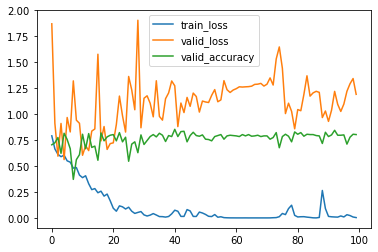

In [20]:
seed_everything(random_seed)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses, _ = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

evaluate(model, test_dataloader)

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### Random choice of augmentation

setting everything to seed 1


100%|██████████| 100/100 [03:16<00:00,  1.96s/it]


Accuracy on the validation:  0.8761904761904762
************************
Quality of the model
Accuracy on test: 0.8299492385786802


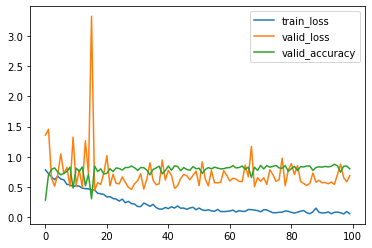

In [21]:
seed_everything(random_seed)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses, _ = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, random_augmentation = True, augmentation_list = augmentation_list)

evaluate(model, test_dataloader)

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

### Choice of augmentation after each epoch

setting everything to seed 1


100%|██████████| 100/100 [04:24<00:00,  2.64s/it]


Accuracy on the validation:  0.8825396825396825
Frequences: {'TimeCycleShift': 70, 'TimeSwapAugmentation': 13, 'TimeRandomSwap': 16, 'TimeReplyMasking': 1}
************************
Quality of the model
Accuracy on test: 0.8629441624365483


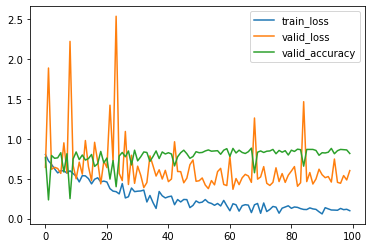

In [22]:
seed_everything(random_seed)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses, aug_probs = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, choice_augmentation = True, augmentation_list = augmentation_list)

evaluate(model, test_dataloader)

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### Random choice of augmentation with frequences

setting everything to seed 1


100%|██████████| 100/100 [03:21<00:00,  2.01s/it]


Accuracy on the validation:  0.8825396825396825
************************
Quality of the model
Accuracy on test: 0.8705583756345178


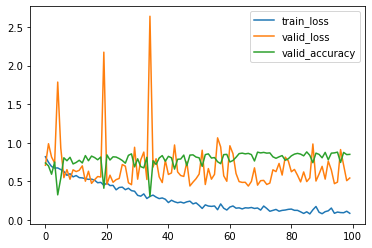

In [23]:
seed_everything(random_seed)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses, _ = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, random_augmentation = True, augmentation_list = augmentation_list, aug_probs = aug_probs)

evaluate(model, test_dataloader)

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

## Resnet 50

#### No augmentation

setting everything to seed 1


100%|██████████| 100/100 [06:52<00:00,  4.13s/it]


Accuracy on the validation:  0.8444444444444444
************************
Quality of the model
Accuracy on test: 0.8401015228426396


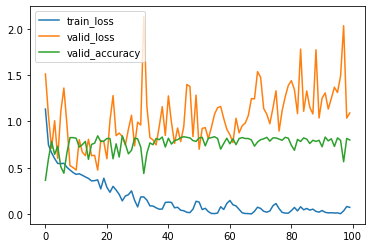

In [24]:
seed_everything(random_seed)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses, _ = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

evaluate(model, test_dataloader)

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### Random choice of augmentation

setting everything to seed 1


100%|██████████| 100/100 [06:59<00:00,  4.19s/it]


Accuracy on the validation:  0.8507936507936508
************************
Quality of the model
Accuracy on test: 0.8426395939086294


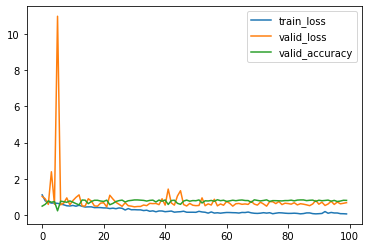

In [25]:
seed_everything(random_seed)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses, _ = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, random_augmentation = True, augmentation_list = augmentation_list)

evaluate(model, test_dataloader)

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

### Choice of augmentation after each epoch

setting everything to seed 1


100%|██████████| 100/100 [09:02<00:00,  5.42s/it]


Accuracy on the validation:  0.8603174603174604
Frequences: {'TimeCycleShift': 72, 'TimeSwapAugmentation': 6, 'TimeRandomSwap': 18, 'TimeReplyMasking': 4}
************************
Quality of the model
Accuracy on test: 0.8578680203045685


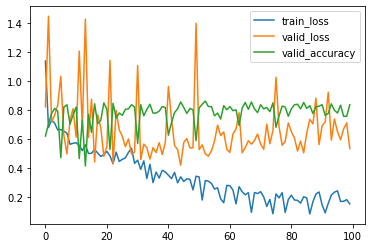

In [26]:
seed_everything(random_seed)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses, aug_probs = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, choice_augmentation = True, augmentation_list = augmentation_list)

evaluate(model, test_dataloader)

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### Random choice of augmentation with frequences

setting everything to seed 1


100%|██████████| 100/100 [07:03<00:00,  4.24s/it]


Accuracy on the validation:  0.8666666666666667
************************
Quality of the model
Accuracy on test: 0.8553299492385786


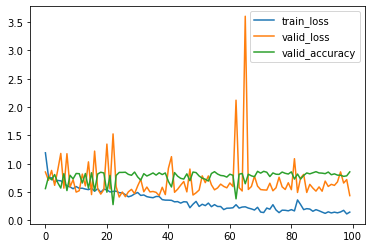

In [27]:
seed_everything(random_seed)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses, _ = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, random_augmentation = True, augmentation_list = augmentation_list, aug_probs = aug_probs)

evaluate(model, test_dataloader)

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

# Random seed = 42

In [28]:
random_seed = 42

keys = np.arange(len(data))
train_keys, test_keys = train_test_split(keys, train_size=train_size, random_state=random_seed)
train_keys, valid_keys = train_test_split(train_keys, train_size=train_size, random_state=random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

## Resnet 18

#### No augmentation

setting everything to seed 42


100%|██████████| 100/100 [03:08<00:00,  1.88s/it]


Accuracy on the validation:  0.8285714285714286
************************
Quality of the model
Accuracy on test: 0.8020304568527918


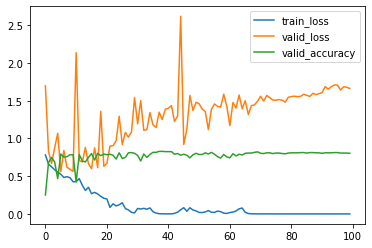

In [29]:
seed_everything(random_seed)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses, _ = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

evaluate(model, test_dataloader)

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### Random choice of augmentation

setting everything to seed 42


100%|██████████| 100/100 [03:15<00:00,  1.96s/it]


Accuracy on the validation:  0.8634920634920635
************************
Quality of the model
Accuracy on test: 0.8426395939086294


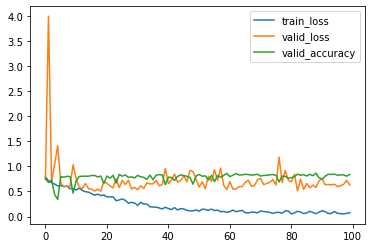

In [30]:
seed_everything(random_seed)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses, _ = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, random_augmentation = True, augmentation_list = augmentation_list)

evaluate(model, test_dataloader)

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

### Choice of augmentation after each epoch

setting everything to seed 42


100%|██████████| 100/100 [04:23<00:00,  2.64s/it]


Accuracy on the validation:  0.8761904761904762
Frequences: {'TimeCycleShift': 63, 'TimeSwapAugmentation': 12, 'TimeRandomSwap': 23, 'TimeReplyMasking': 2}
************************
Quality of the model
Accuracy on test: 0.8807106598984772


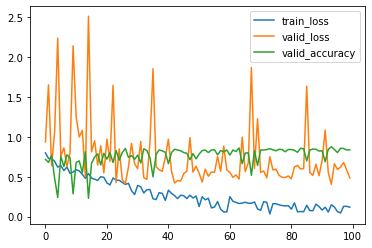

In [31]:
seed_everything(random_seed)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses, aug_probs = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, choice_augmentation = True, augmentation_list = augmentation_list)

evaluate(model, test_dataloader)

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### Random choice of augmentation with frequences

  0%|          | 0/100 [00:00<?, ?it/s]

setting everything to seed 42


100%|██████████| 100/100 [03:19<00:00,  2.00s/it]


Accuracy on the validation:  0.8666666666666667
************************
Quality of the model
Accuracy on test: 0.850253807106599


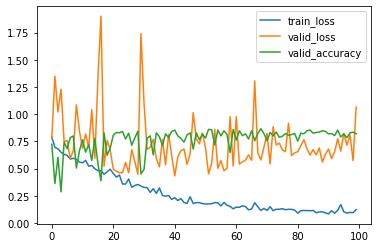

In [32]:
seed_everything(random_seed)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses, _ = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, random_augmentation = True, augmentation_list = augmentation_list, aug_probs = aug_probs)

evaluate(model, test_dataloader)

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

## Resnet 50

#### No augmentation

setting everything to seed 42


100%|██████████| 100/100 [06:54<00:00,  4.14s/it]


Accuracy on the validation:  0.8380952380952381
************************
Quality of the model
Accuracy on test: 0.7791878172588832


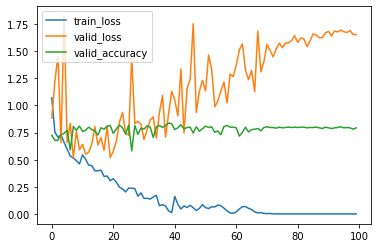

In [33]:
seed_everything(random_seed)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses, _ = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

evaluate(model, test_dataloader)

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### Random choice of augmentation

setting everything to seed 42


100%|██████████| 100/100 [07:04<00:00,  4.25s/it]


Accuracy on the validation:  0.8507936507936508
************************
Quality of the model
Accuracy on test: 0.8477157360406091


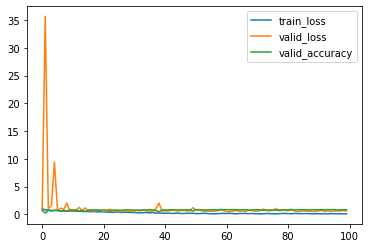

In [34]:
seed_everything(random_seed)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses, _ = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, random_augmentation = True, augmentation_list = augmentation_list)

evaluate(model, test_dataloader)

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

### Choice of augmentation after each epoch

setting everything to seed 42


100%|██████████| 100/100 [09:14<00:00,  5.55s/it]


Accuracy on the validation:  0.8825396825396825
Frequences: {'TimeCycleShift': 70, 'TimeSwapAugmentation': 10, 'TimeRandomSwap': 16, 'TimeReplyMasking': 4}
************************
Quality of the model
Accuracy on test: 0.8426395939086294


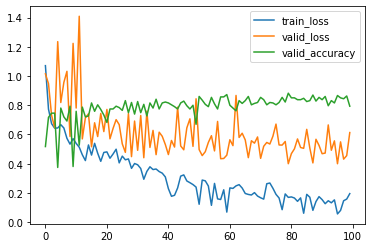

In [35]:
seed_everything(random_seed)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses, aug_probs = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, choice_augmentation = True, augmentation_list = augmentation_list)

evaluate(model, test_dataloader)

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### Random choice of augmentation with frequences

setting everything to seed 42


100%|██████████| 100/100 [07:07<00:00,  4.27s/it]


Accuracy on the validation:  0.873015873015873
************************
Quality of the model
Accuracy on test: 0.8654822335025381


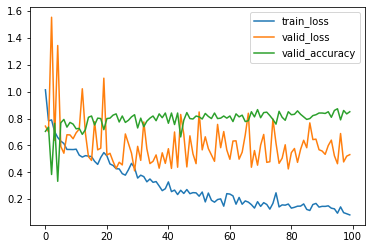

In [36]:
seed_everything(random_seed)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses, _ = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, random_augmentation = True, augmentation_list = augmentation_list, aug_probs = aug_probs)

evaluate(model, test_dataloader)

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

# Random seed = 10

In [37]:
random_seed = 10

keys = np.arange(len(data))
train_keys, test_keys = train_test_split(keys, train_size=train_size, random_state=random_seed)
train_keys, valid_keys = train_test_split(train_keys, train_size=train_size, random_state=random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

## Resnet 18

#### No augmentation

setting everything to seed 10


100%|██████████| 100/100 [03:08<00:00,  1.89s/it]


Accuracy on the validation:  0.8095238095238095
************************
Quality of the model
Accuracy on test: 0.8197969543147208


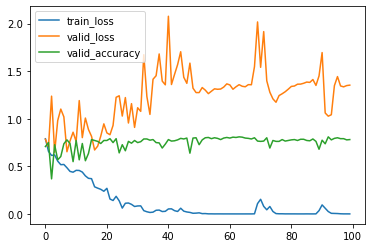

In [38]:
seed_everything(random_seed)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses, _ = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

evaluate(model, test_dataloader)

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### Random choice of augmentation

setting everything to seed 10


100%|██████████| 100/100 [03:16<00:00,  1.97s/it]


Accuracy on the validation:  0.8412698412698413
************************
Quality of the model
Accuracy on test: 0.8375634517766497


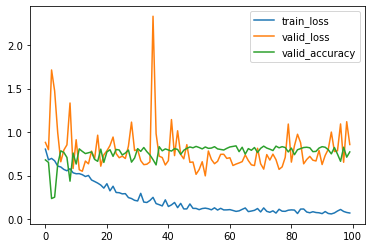

In [39]:
seed_everything(random_seed)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses, _ = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, random_augmentation = True, augmentation_list = augmentation_list)

evaluate(model, test_dataloader)

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

### Choice of augmentation after each epoch

setting everything to seed 10


100%|██████████| 100/100 [04:33<00:00,  2.74s/it]


Accuracy on the validation:  0.873015873015873
Frequences: {'TimeCycleShift': 58, 'TimeSwapAugmentation': 12, 'TimeRandomSwap': 22, 'TimeReplyMasking': 8}
************************
Quality of the model
Accuracy on test: 0.8756345177664975


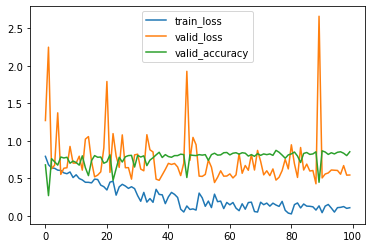

In [40]:
seed_everything(random_seed)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses, aug_probs = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, choice_augmentation = True, augmentation_list = augmentation_list)

evaluate(model, test_dataloader)

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### Random choice of augmentation with frequences

setting everything to seed 10


100%|██████████| 100/100 [03:27<00:00,  2.07s/it]


Accuracy on the validation:  0.8666666666666667
************************
Quality of the model
Accuracy on test: 0.8934010152284264


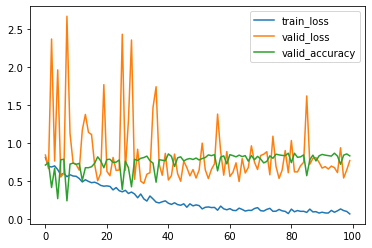

In [41]:
seed_everything(random_seed)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses, _ = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, random_augmentation = True, augmentation_list = augmentation_list, aug_probs = aug_probs)

evaluate(model, test_dataloader)

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

## Resnet 50

#### No augmentation

setting everything to seed 10


100%|██████████| 100/100 [06:57<00:00,  4.17s/it]


Accuracy on the validation:  0.8285714285714286
************************
Quality of the model
Accuracy on test: 0.8020304568527918


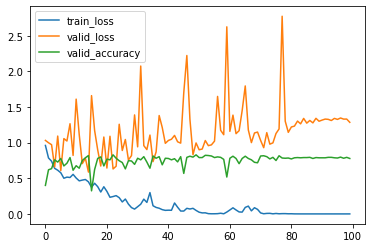

In [42]:
seed_everything(random_seed)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses, _ = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

evaluate(model, test_dataloader)

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### Random choice of augmentation

setting everything to seed 10


100%|██████████| 100/100 [07:05<00:00,  4.25s/it]


Accuracy on the validation:  0.8571428571428571
************************
Quality of the model
Accuracy on test: 0.8604060913705583


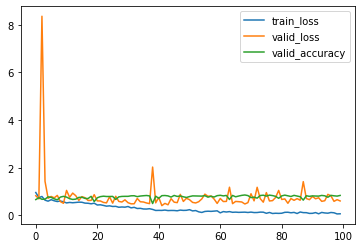

In [43]:
seed_everything(random_seed)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses, _ = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, random_augmentation = True, augmentation_list = augmentation_list)

evaluate(model, test_dataloader)

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

### Choice of augmentation after each epoch

setting everything to seed 10


100%|██████████| 100/100 [09:15<00:00,  5.55s/it]


Accuracy on the validation:  0.8761904761904762
Frequences: {'TimeCycleShift': 65, 'TimeSwapAugmentation': 15, 'TimeRandomSwap': 14, 'TimeReplyMasking': 6}
************************
Quality of the model
Accuracy on test: 0.8654822335025381


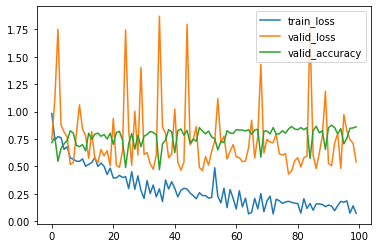

In [44]:
seed_everything(random_seed)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses, aug_probs = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, choice_augmentation = True, augmentation_list = augmentation_list)

evaluate(model, test_dataloader)

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### Random choice of augmentation with frequences

setting everything to seed 10


100%|██████████| 100/100 [07:12<00:00,  4.32s/it]


Accuracy on the validation:  0.8793650793650793
************************
Quality of the model
Accuracy on test: 0.8477157360406091


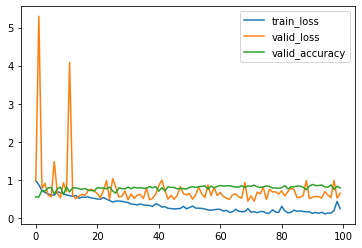

In [45]:
seed_everything(random_seed)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses, _ = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, random_augmentation = True, augmentation_list = augmentation_list, aug_probs = aug_probs)

evaluate(model, test_dataloader)

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

# Random seed = 15

In [46]:
random_seed = 15

keys = np.arange(len(data))
train_keys, test_keys = train_test_split(keys, train_size=train_size, random_state=random_seed)
train_keys, valid_keys = train_test_split(train_keys, train_size=train_size, random_state=random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

## Resnet 18

#### No augmentation

setting everything to seed 15


100%|██████████| 100/100 [03:15<00:00,  1.95s/it]


Accuracy on the validation:  0.8158730158730159
************************
Quality of the model
Accuracy on test: 0.8223350253807107


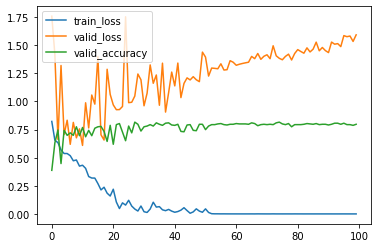

In [47]:
seed_everything(random_seed)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses, _ = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

evaluate(model, test_dataloader)

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### Random choice of augmentation

setting everything to seed 15


100%|██████████| 100/100 [03:24<00:00,  2.05s/it]


Accuracy on the validation:  0.8539682539682539
************************
Quality of the model
Accuracy on test: 0.8654822335025381


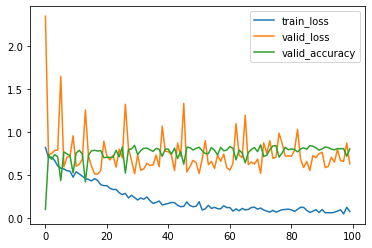

In [48]:
seed_everything(random_seed)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses, _ = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, random_augmentation = True, augmentation_list = augmentation_list)

evaluate(model, test_dataloader)

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

### Choice of augmentation after each epoch

setting everything to seed 15


100%|██████████| 100/100 [04:34<00:00,  2.74s/it]


Accuracy on the validation:  0.8507936507936508
Frequences: {'TimeCycleShift': 49, 'TimeSwapAugmentation': 18, 'TimeRandomSwap': 30, 'TimeReplyMasking': 3}
************************
Quality of the model
Accuracy on test: 0.8705583756345178


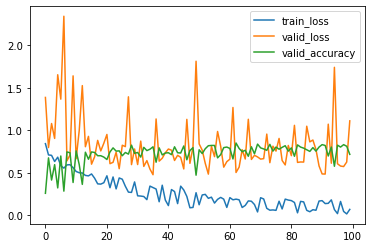

In [49]:
seed_everything(random_seed)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses, aug_probs = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, choice_augmentation = True, augmentation_list = augmentation_list)

evaluate(model, test_dataloader)

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### Random choice of augmentation with frequences

setting everything to seed 15


100%|██████████| 100/100 [03:29<00:00,  2.09s/it]


Accuracy on the validation:  0.8634920634920635
************************
Quality of the model
Accuracy on test: 0.8730964467005076


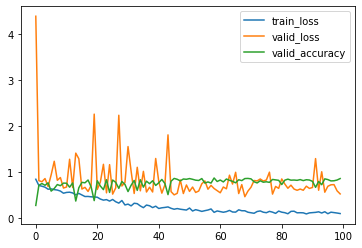

In [50]:
seed_everything(random_seed)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses, _ = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, random_augmentation = True, augmentation_list = augmentation_list, aug_probs = aug_probs)

evaluate(model, test_dataloader)

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

## Resnet 50

#### No augmentation

setting everything to seed 15


100%|██████████| 100/100 [06:58<00:00,  4.18s/it]


Accuracy on the validation:  0.834920634920635
************************
Quality of the model
Accuracy on test: 0.8350253807106599


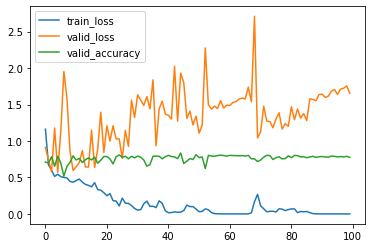

In [51]:
seed_everything(random_seed)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses, _ = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

evaluate(model, test_dataloader)

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### Random choice of augmentation

setting everything to seed 15


100%|██████████| 100/100 [07:07<00:00,  4.27s/it]


Accuracy on the validation:  0.8571428571428571
************************
Quality of the model
Accuracy on test: 0.9137055837563451


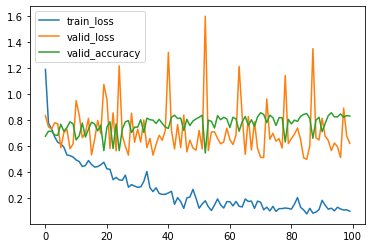

In [52]:
seed_everything(random_seed)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses, _ = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, random_augmentation = True, augmentation_list = augmentation_list)

evaluate(model, test_dataloader)

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

### Choice of augmentation after each epoch

setting everything to seed 15


100%|██████████| 100/100 [09:17<00:00,  5.58s/it]


Accuracy on the validation:  0.8412698412698413
Frequences: {'TimeCycleShift': 64, 'TimeSwapAugmentation': 11, 'TimeRandomSwap': 22, 'TimeReplyMasking': 3}
************************
Quality of the model
Accuracy on test: 0.8477157360406091


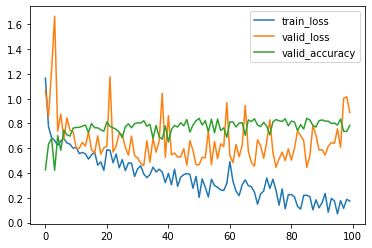

In [53]:
seed_everything(random_seed)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses, aug_probs = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, choice_augmentation = True, augmentation_list = augmentation_list)

evaluate(model, test_dataloader)

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### Random choice of augmentation with frequences

setting everything to seed 15


100%|██████████| 100/100 [07:11<00:00,  4.32s/it]


Accuracy on the validation:  0.8698412698412699
************************
Quality of the model
Accuracy on test: 0.8883248730964467


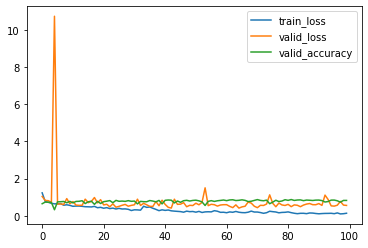

In [54]:
seed_everything(random_seed)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses, _ = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, random_augmentation = True, augmentation_list = augmentation_list, aug_probs = aug_probs)

evaluate(model, test_dataloader)

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

# Random seed = 23

In [55]:
random_seed = 23

keys = np.arange(len(data))
train_keys, test_keys = train_test_split(keys, train_size=train_size, random_state=random_seed)
train_keys, valid_keys = train_test_split(train_keys, train_size=train_size, random_state=random_seed)

train_dataset = HeartbeatSounds(mode='train', data = data, labels = labels, keys = train_keys)
valid_dataset = HeartbeatSounds(mode='valid', data = data, labels = labels, keys = valid_keys)
test_dataset = HeartbeatSounds(mode='test', data = data, labels = labels, keys = test_keys)

## Resnet 18

#### No augmentation

setting everything to seed 23


100%|██████████| 100/100 [03:14<00:00,  1.95s/it]


Accuracy on the validation:  0.8539682539682539
************************
Quality of the model
Accuracy on test: 0.8071065989847716


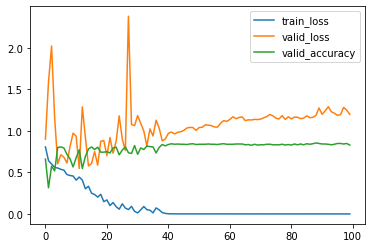

In [56]:
seed_everything(random_seed)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses, _ = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

evaluate(model, test_dataloader)

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### Random choice of augmentation

setting everything to seed 23


100%|██████████| 100/100 [03:22<00:00,  2.03s/it]


Accuracy on the validation:  0.8476190476190476
************************
Quality of the model
Accuracy on test: 0.8223350253807107


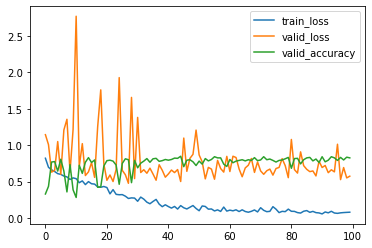

In [57]:
seed_everything(random_seed)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses, _ = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, random_augmentation = True, augmentation_list = augmentation_list)

evaluate(model, test_dataloader)

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

### Choice of augmentation after each epoch

setting everything to seed 23


100%|██████████| 100/100 [04:35<00:00,  2.76s/it]


Accuracy on the validation:  0.8825396825396825
Frequences: {'TimeCycleShift': 64, 'TimeSwapAugmentation': 12, 'TimeRandomSwap': 17, 'TimeReplyMasking': 7}
************************
Quality of the model
Accuracy on test: 0.8781725888324873


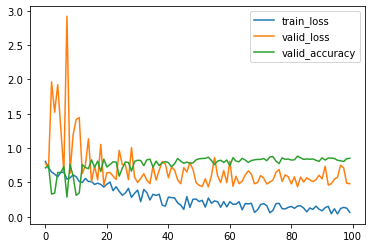

In [58]:
seed_everything(random_seed)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses, aug_probs = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, choice_augmentation = True, augmentation_list = augmentation_list)

evaluate(model, test_dataloader)

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### Random choice of augmentation with frequences

setting everything to seed 23


100%|██████████| 100/100 [03:30<00:00,  2.10s/it]


Accuracy on the validation:  0.873015873015873
************************
Quality of the model
Accuracy on test: 0.8705583756345178


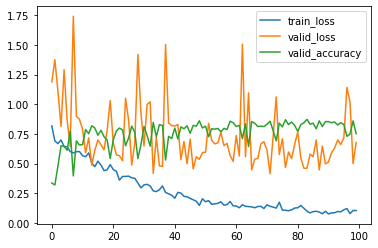

In [59]:
seed_everything(random_seed)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet18()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses, _ = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, random_augmentation = True, augmentation_list = augmentation_list, aug_probs = aug_probs)

evaluate(model, test_dataloader)

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

## Resnet 50

#### No augmentation

setting everything to seed 23


100%|██████████| 100/100 [06:59<00:00,  4.20s/it]


Accuracy on the validation:  0.834920634920635
************************
Quality of the model
Accuracy on test: 0.8350253807106599


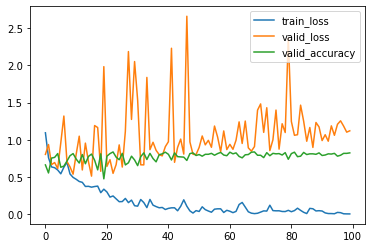

In [60]:
seed_everything(random_seed)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses, _ = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer)

evaluate(model, test_dataloader)

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### Random choice of augmentation

setting everything to seed 23


100%|██████████| 100/100 [07:08<00:00,  4.28s/it]


Accuracy on the validation:  0.8698412698412699
************************
Quality of the model
Accuracy on test: 0.8527918781725888


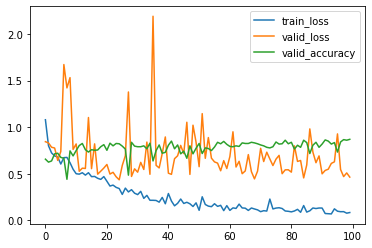

In [61]:
seed_everything(random_seed)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses, _ = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, random_augmentation = True, augmentation_list = augmentation_list)

evaluate(model, test_dataloader)

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

### Choice of augmentation after each epoch

setting everything to seed 23


100%|██████████| 100/100 [09:17<00:00,  5.58s/it]


Accuracy on the validation:  0.8571428571428571
Frequences: {'TimeCycleShift': 60, 'TimeSwapAugmentation': 7, 'TimeRandomSwap': 26, 'TimeReplyMasking': 7}
************************
Quality of the model
Accuracy on test: 0.8781725888324873


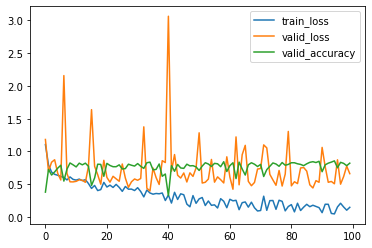

In [62]:
seed_everything(random_seed)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses, aug_probs = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, choice_augmentation = True, augmentation_list = augmentation_list)

evaluate(model, test_dataloader)

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()

#### Random choice of augmentation with frequences

setting everything to seed 23


100%|██████████| 100/100 [07:12<00:00,  4.32s/it]


Accuracy on the validation:  0.8571428571428571
************************
Quality of the model
Accuracy on test: 0.8654822335025381


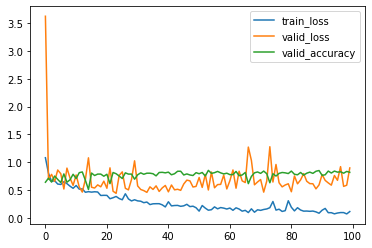

In [63]:
seed_everything(random_seed)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, worker_init_fn=worker_init_fn)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, worker_init_fn=worker_init_fn)

model = resnet50()
num_ftrs = model.fc.in_features
model.fc = torch.nn.Linear(num_ftrs, 3)
model = model.to(device)

epochs = 100
criterion = torch.nn.CrossEntropyLoss()
criterion = criterion.to(device)
optimizer = torch.optim.Adam(model.parameters())

model, losses, _ = train(model, criterion, train_dataloader, valid_dataloader, epochs, optimizer, random_augmentation = True, augmentation_list = augmentation_list, aug_probs = aug_probs)

evaluate(model, test_dataloader)

plt.plot(np.arange(epochs), losses[0], label = 'train_loss')
plt.plot(np.arange(epochs), losses[1], label = 'valid_loss')
plt.plot(np.arange(epochs), losses[2], label = 'valid_accuracy')
plt.legend()
plt.show()